In [8]:
# add the parent directory to the system path:
import sys
from pathlib import Path
parent_dir = Path('..').resolve() 
sys.path.append(str(parent_dir)) 

import pandas as pds
import numpy as np
import matplotlib.pyplot as plt

import sympy
import argparse
import equations
import data
from gp_utils import run_gp
from interpolate import num_diff, num_diff_gp
import pickle
import os
import time

##### bifurcation:

In [9]:
np.random.seed(999)
ode_name = 'SelkovODE'

ode_param=None
ode_param_1 = [0.4, 0.1]
ode_param_2 = [0.6, 0.1]
ode_param_3 = [0.9, 0.1]
ode_param_4 = [0.3, 0.1]

freq = 10 #!!!
freq2 = 10 #!!!
T2 = 20 #!!!

x_id = 0 
n_sample = 10 
noise_ratio = 0.01
seed = 0

# specify ODE:
ode = equations.get_ode(ode_name, ode_param)
ode_1 = equations.get_ode(ode_name, ode_param_1)
ode_2 = equations.get_ode(ode_name, ode_param_2)
ode_3 = equations.get_ode(ode_name, ode_param_3)
ode_4 = equations.get_ode(ode_name, ode_param_4)

T = ode.T
init_low = ode.init_low
print(init_low)
init_high = ode.init_high
print(init_high)


# data simulation: 

# correct trajectory:
dg0 = data.DataGenerator(ode, T, freq, 1, 0, 0.05, 0.05) 
yt0 = dg0.generate_data()
print(np.shape(yt0))
dg0_1 = data.DataGenerator(ode_1, T, freq, 1, 0, 0.05, 0.05) 
yt0_1 = dg0_1.generate_data()
dg0_2 = data.DataGenerator(ode_2, T, freq, 1, 0, 0.05, 0.05) 
yt0_2 = dg0_2.generate_data()
dg0_3 = data.DataGenerator(ode_3, T, freq, 1, 0, 0.05, 0.05)
yt0_3 = dg0_3.generate_data()
dg0_4 = data.DataGenerator(ode_4, T, freq, 1, 0, 0.05, 0.05) 
yt0_4 = dg0_4.generate_data()

0
0.1
(151, 1, 2)


In [3]:
# idea: moltiplichiamo std_base per un coefficiente crescente che valga 1 per l = 9.701279781815092, 0 per l = 0, etc.

# lengths of the trajectories:

def length(yt):
    # estimates the length of a curve
    x = yt[:, 0, 0]
    y = yt[:, 0, 1]
    dx = np.diff(x)
    dy = np.diff(y)
    d = np.sqrt(dx**2 + dy**2)
    l = np.sum(d)
    return l

l = length(yt0)
l_1 = length(yt0_1)
l_2 = length(yt0_2)
l_3 = length(yt0_3)
l_4 = length(yt0_4)
print(l, l_1, l_2, l_3, l_4)

# scaling coefficients:
def coeff(x):
    return x / 9.701279781815092

k = coeff(l)
k_1 = coeff(l_1)
k_2 = coeff(l_2)
k_3 = coeff(l_3)
k_4 = coeff(l_4)
print(k, k_1, k_2, k_3, k_4)

window_sl = 0.05
window_sl1 = window_sl * k_1
window_sl2 = window_sl * k_2
window_sl3 = window_sl * k_3
window_sl4 = window_sl * k_4
print(window_sl, window_sl1, window_sl2, window_sl3, window_sl4)


9.701279781815092 3.228170672441758 6.995997099511914 10.14156742393638 1.8385890821697124
1.0 0.33275719750840677 0.7211416696409281 1.0453844907088032 0.18952026160673366
0.05 0.01663785987542034 0.036057083482046406 0.05226922453544017 0.009476013080336684


In [4]:
noise_sigma = ode.std_base * noise_ratio # RMK. noise_ratio is the standardized level for noise, noise_sigma is specific for the equation at hand
noise_sigma_1 = ode.std_base * k_1 * noise_ratio
noise_sigma_2 = ode.std_base * k_2 * noise_ratio
noise_sigma_3 = ode.std_base * k_3 * noise_ratio
noise_sigma_4 = ode.std_base * k_4 * noise_ratio
print(noise_sigma, noise_sigma_1, noise_sigma_2, noise_sigma_3, noise_sigma_4)


# noisy trajectories:
dg = data.DataGenerator(ode, T, freq, n_sample, noise_sigma, init_low, init_high) 
yt = dg.generate_data()
#print(np.shape(yt))
dg_1 = data.DataGenerator(ode_1, T, freq, n_sample, noise_sigma_1, init_low, init_high * k_1) 
yt_1 = dg_1.generate_data()
dg_2 = data.DataGenerator(ode_2, T, freq, n_sample, noise_sigma_2, init_low, init_high * k_2) 
yt0_2 = dg_2.generate_data()
dg_3 = data.DataGenerator(ode_3, T, freq, n_sample, noise_sigma_3, init_low, init_high * k_3) 
yt_3 = dg_3.generate_data()

dg_1_s = data.DataGenerator(ode_1, T, freq, n_sample, noise_sigma, init_low, init_high) 
yt_1_s = dg_1_s.generate_data()

# RMK. anche specificando init_high=0.05 e init_low=0.05 il punto di partenza è differente, ed è x=0.12410901, y=0.04609579 

0.005641061000000001 0.0018771036493339707 0.004068004148086324 0.005897077680542293 0.0010690953564595426


In [15]:
# longer trajectories:
dg0_T = data.DataGenerator(ode, T2, freq2, 1, 0, 0.05, 0.05) # RMK. non usiamo il seed per generare i dati!!
yt0_T = dg0_T.generate_data()
print(np.shape(yt0_T))
dg0_1T = data.DataGenerator(ode_1, T2, freq2, 1, 0, 0.05, 0.05) # RMK. non usiamo il seed per generare i dati!!
yt0_1T = dg0_1T.generate_data()
dg0_2T = data.DataGenerator(ode_2, T2, freq2, 1, 0, 0.05, 0.05) # RMK. non usiamo il seed per generare i dati!!
yt0_2T = dg0_2T.generate_data()
dg0_3T = data.DataGenerator(ode_3, T2, freq2, 1, 0, 0.05, 0.05) # RMK. non usiamo il seed per generare i dati!!
yt0_3T = dg0_3T.generate_data()

(201, 1, 2)


In [16]:
#dev: tiem vector
dt = 1 / freq
print(dt)
time_vector = np.arange(0, ode.T + dt, dt)
print(np.shape(time_vector))

dt2 = 1 / freq2
print(dt2)
time_vector2 = np.arange(0, T2 + dt2, dt2)
print(np.shape(time_vector2))


0.1
(151,)
0.1
(201,)


In [17]:
print(yt[0:5, 0, 0]) # print first sample, variable x 
print(yt[0:5, 0, 1]) # print first sample, variable a -> given its definiton, a is constant over time
print(yt0[0:5, 0, 0]) 
print(yt0[0:5, 0, 1]) 

[0.16090583 0.22730216 0.3043055  0.37698622 0.45204402]
[0.07804168 0.07038173 0.07301904 0.07677048 0.06639354]
[0.12410901 0.19746864 0.27008854 0.34197652 0.41313904]
[0.04609579 0.04327612 0.04142863 0.04045343 0.04026135]


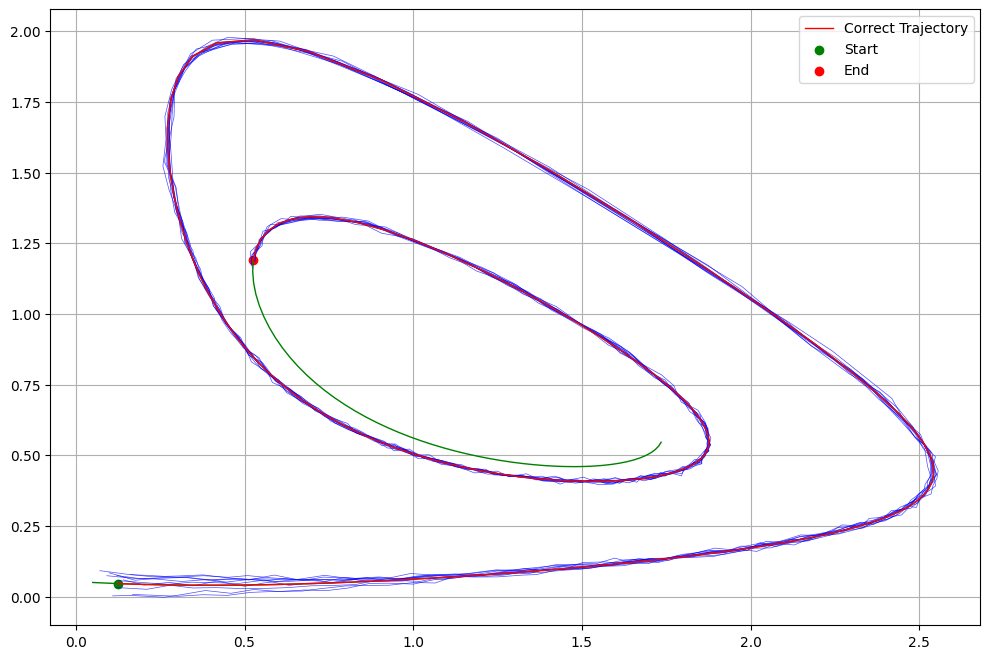

In [18]:
plt.figure(figsize=(12, 8))

plt.plot(yt0_T[:, 0, 0], yt0_T[:, 0, 1], color='green', linewidth=1.0)

for i in range(n_sample):
    plt.plot(yt[:, i, 0], yt[:, i, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(yt0[:, 0, 0], yt0[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

plt.scatter(yt0[:, 0, 0][0], yt0[:, 0, 1][0], color='green', label='Start')
plt.scatter(yt0[:, 0, 0][-1], yt0[:, 0, 1][-1], color='red', label='End')



#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

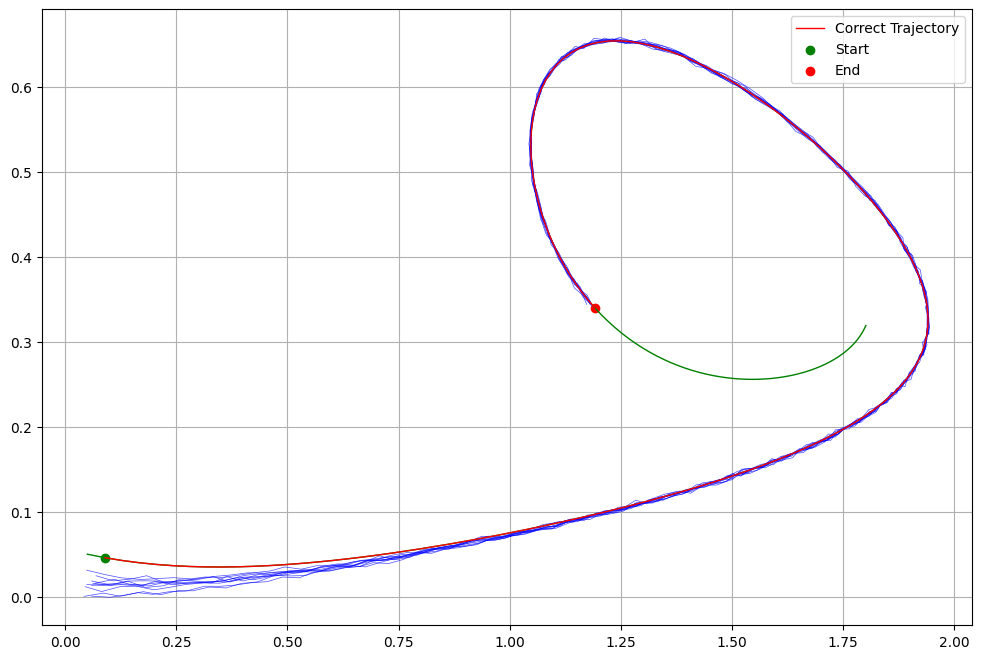

In [19]:
plt.figure(figsize=(12, 8))

plt.plot(yt0_1T[:, 0, 0], yt0_1T[:, 0, 1], color='green', linewidth=1.0)

for i in range(n_sample):
    plt.plot(yt_1[:, i, 0], yt_1[:, i, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(yt0_1[:, 0, 0], yt0_1[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

plt.scatter(yt0_1[:, 0, 0][0], yt0_1[:, 0, 1][0], color='green', label='Start')
plt.scatter(yt0_1[:, 0, 0][-1], yt0_1[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

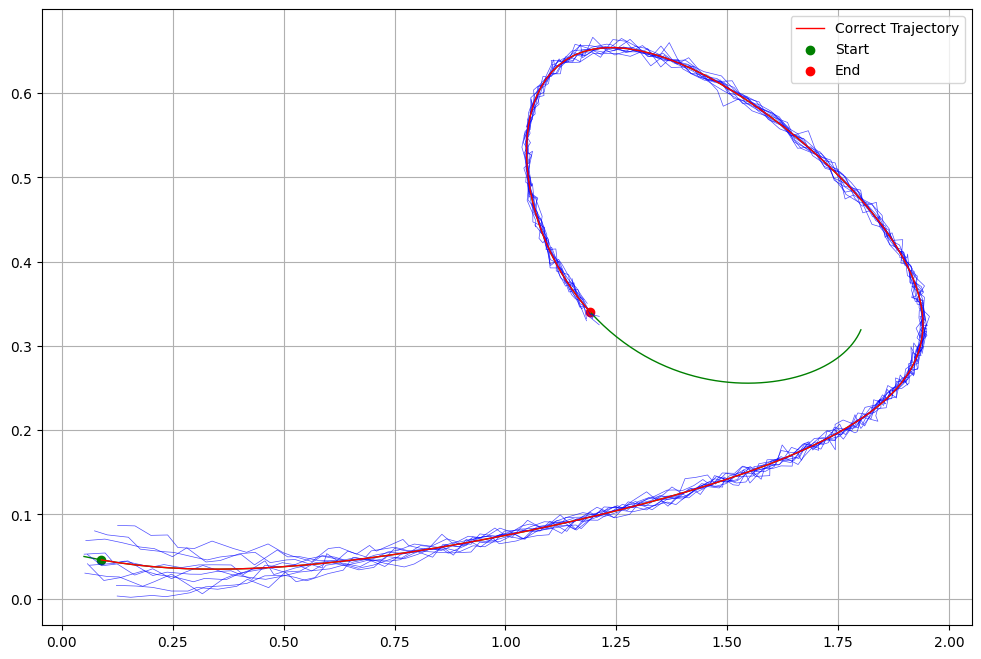

In [37]:
plt.figure(figsize=(12, 8))

plt.plot(yt0_1T[:, 0, 0], yt0_1T[:, 0, 1], color='green', linewidth=1.0)

for i in range(n_sample):
    plt.plot(yt_1_s[:, i, 0], yt_1_s[:, i, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(yt0_1[:, 0, 0], yt0_1[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

plt.scatter(yt0_1[:, 0, 0][0], yt0_1[:, 0, 1][0], color='green', label='Start')
plt.scatter(yt0_1[:, 0, 0][-1], yt0_1[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

Much better and much more fair, we could also scale the starting window, but...

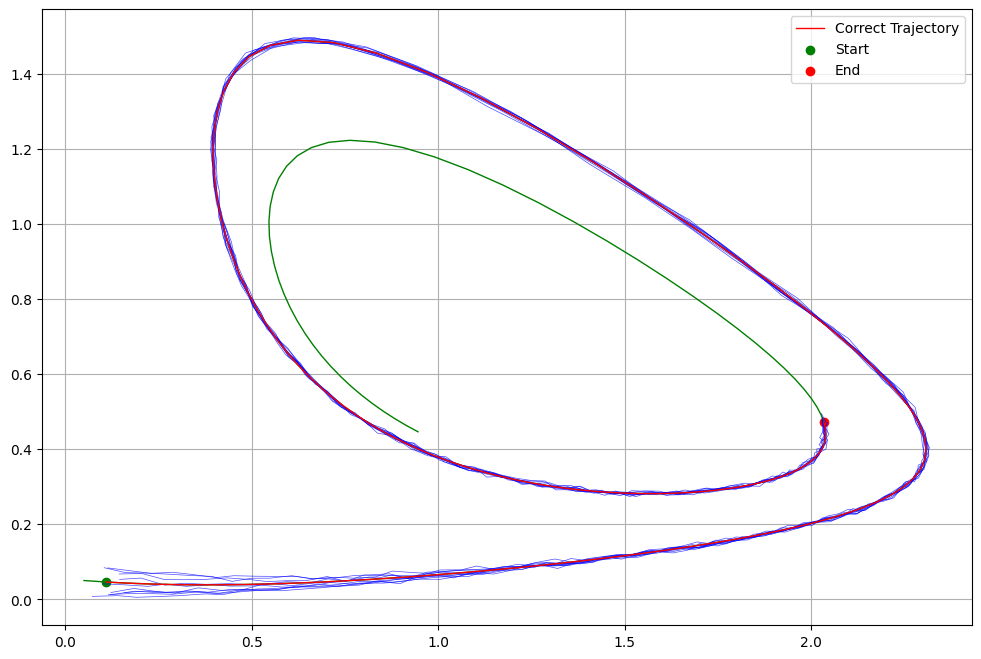

In [38]:
plt.figure(figsize=(12, 8))

plt.plot(yt0_2T[:, 0, 0], yt0_2T[:, 0, 1], color='green', linewidth=1.0)

for i in range(n_sample):
    plt.plot(yt_2[:, i, 0], yt_2[:, i, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(yt0_2[:, 0, 0], yt0_2[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

plt.scatter(yt0_2[:, 0, 0][0], yt0_2[:, 0, 1][0], color='green', label='Start')
plt.scatter(yt0_2[:, 0, 0][-1], yt0_2[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

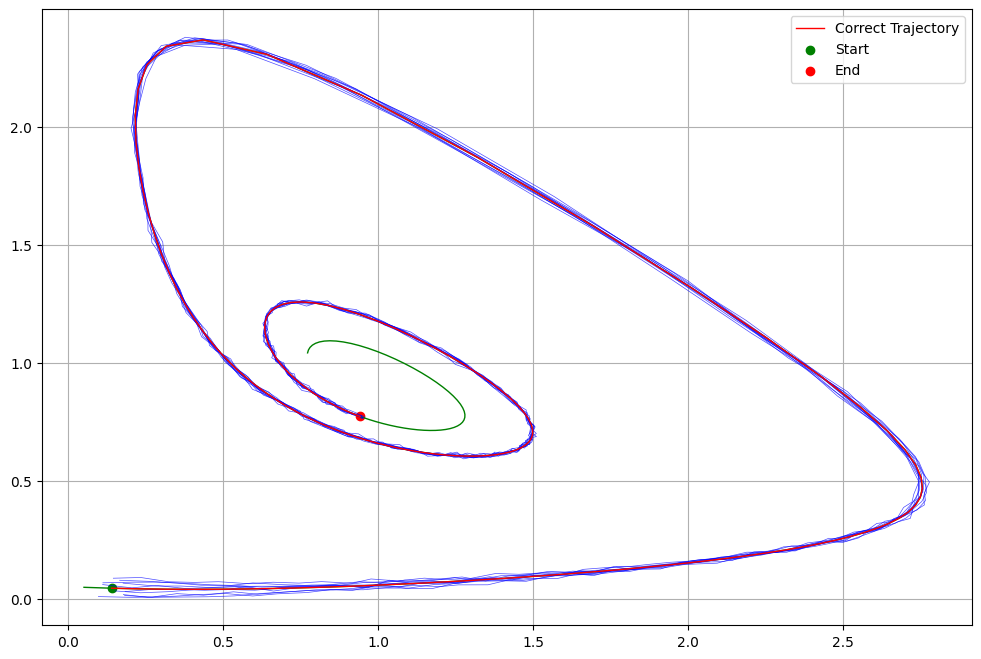

In [39]:
plt.figure(figsize=(12, 8))

plt.plot(yt0_3T[:, 0, 0], yt0_3T[:, 0, 1], color='green', linewidth=1.0)

for i in range(n_sample):
    plt.plot(yt_3[:, i, 0], yt_3[:, i, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(yt0_3[:, 0, 0], yt0_3[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

plt.scatter(yt0_3[:, 0, 0][0], yt0_3[:, 0, 1][0], color='green', label='Start')
plt.scatter(yt0_3[:, 0, 0][-1], yt0_3[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

##### plots x report:

In [10]:
np.random.seed(999)
ode_name = 'SelkovODE'

ode_param=None
ode_param_1 = [0.4, 0.1]
ode_param_2 = [0.6, 0.1]
ode_param_3 = [0.9, 0.1]
ode_param_4 = [0.3, 0.1]

freq = 10
x_id = 0 
n_sample = 10 
noise_ratio = 0.01
seed = 0

# specify ODE:
ode = equations.get_ode(ode_name, ode_param)
ode_1 = equations.get_ode(ode_name, ode_param_1)
ode_2 = equations.get_ode(ode_name, ode_param_2)
ode_3 = equations.get_ode(ode_name, ode_param_3)
ode_4 = equations.get_ode(ode_name, ode_param_4)

T = 25
init_low = ode.init_low
init_high = ode.init_high


# data simulation: 
# correct trajectory:
dg0 = data.DataGenerator(ode, T, freq, 1, 0, 0.05, 0.05) 
yt0 = dg0.generate_data()
print(np.shape(yt0))
dg0_1 = data.DataGenerator(ode_1, T, freq, 1, 0, 0.05, 0.05) 
yt0_1 = dg0_1.generate_data()
dg0_2 = data.DataGenerator(ode_2, T, freq, 1, 0, 0.05, 0.05) 
yt0_2 = dg0_2.generate_data()
dg0_3 = data.DataGenerator(ode_3, T, freq, 1, 0, 0.05, 0.05)
yt0_3 = dg0_3.generate_data()
dg0_4 = data.DataGenerator(ode_4, T, freq, 1, 0, 0.05, 0.05) 
yt0_4 = dg0_4.generate_data()

(251, 1, 2)


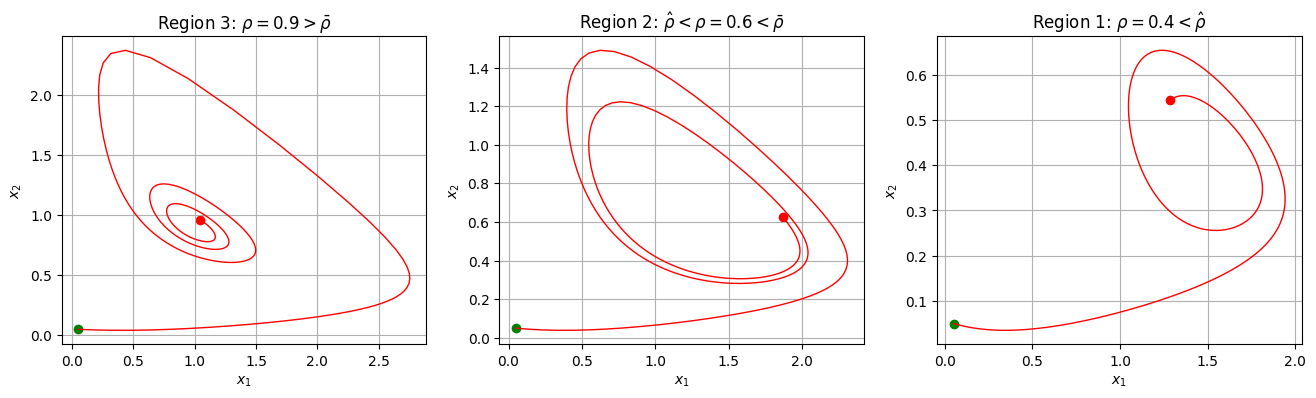

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].plot(yt0_3[:, 0, 0], yt0_3[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')
axs[0].scatter(yt0_3[:, 0, 0][0], yt0_3[:, 0, 1][0], color='green', label='Start')
axs[0].scatter(yt0_3[:, 0, 0][-1], yt0_3[:, 0, 1][-1], color='red', label='End')
axs[0].set_title(r'Region 3: $\rho = 0.9 > \bar{\rho}$')
axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
#axs[0].legend()
axs[0].grid(True)

axs[1].plot(yt0_2[:, 0, 0], yt0_2[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')
axs[1].scatter(yt0_2[:, 0, 0][0], yt0_2[:, 0, 1][0], color='green', label='Start')
axs[1].scatter(yt0_2[:, 0, 0][-1], yt0_2[:, 0, 1][-1], color='red', label='End')
axs[1].set_title(r'Region 2: $\hat{\rho} < \rho = 0.6 < \bar{\rho}$')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
#axs[1].legend()
axs[1].grid(True)

axs[2].plot(yt0_1[:, 0, 0], yt0_1[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')
axs[2].scatter(yt0_1[:, 0, 0][0], yt0_1[:, 0, 1][0], color='green', label='Start')
axs[2].scatter(yt0_1[:, 0, 0][-1], yt0_1[:, 0, 1][-1], color='red', label='End')
axs[2].set_title(r'Region 1: $\rho = 0.4 < \hat{\rho}$')
axs[2].set_xlabel('$x_1$')
axs[2].set_ylabel('$x_2$')
#axs[2].legend()
axs[2].grid(True)